In [6]:
import numpy as np
from tqdm import tqdm
from math import sqrt,exp
import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
from itertools import product
from itertools import combinations
from qutip import *
settings.num_cpus = 100
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 7, 4
# plt.rcParams['figure.dpi'] = 60
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

### Creating Hamiltonian manually

In [7]:
def get_basis(Ek_0):
    sing_basis = ['0u', '0d']
    for i in range(1, len(Ek_0)+1):
        sing_basis +=  [str(i)+'u', str(i)+'d']
    basis = []
    for i in range(2*len(Ek_0)+3):
        basis += combinations(sing_basis, i)
    return basis

    
    
def diag(Ek_0, V, U):
    basis = get_basis(Ek_0)
    H = np.zeros([len(basis)]*2)
    for i, state in enumerate(basis):
        if ('0u' in state and '0d' in state) or ('0u' not in state and '0d' not in state):
            H[i][i] += U/4
        else:
            H[i][i] -= U/4
        for k in range(1, len(Ek_0)+1):
            if str(k)+'u' not in state and str(k)+'d' not in state:
                H[i][i] -= Ek_0[k-1]
            elif str(k)+'u' in state and str(k)+'d' in state:
                H[i][i] += Ek_0[k-1]
    return H


def off_diag(Ek_0, V, U):
    basis = get_basis(Ek_0)
    H = np.zeros([len(basis)]*2)
    for k in range(1, len(Ek_0)+1):
        for (i, si), (j, sj) in product(enumerate(basis), enumerate(basis)):
            si = list(si)
            sj = list(sj)
            if i==j or si == () or sj == ():
                continue
            if set(si + [str(k)+'u']) == set(sj + ['0u']) or set(sj + [str(k)+'u']) == set(si + ['0u']):
                H[i][j] = V
            if set(si + [str(k)+'d']) == set(sj + ['0d']) or set(sj + [str(k)+'d']) == set(si + ['0d']):
                H[i][j] = V
    return H
        
    
def get_nd(Ek_0):
    basis = get_basis(Ek_0)
    nd_up = np.zeros([len(basis)]*2)
    nd_dn = np.zeros([len(basis)]*2)
    for i, state in enumerate(basis):
        if '0u' in state:
            nd_up [i][i] = 1
        if '0d' in state:
            nd_dn [i][i] = 1
    return nd_up, nd_dn

### Creating Hamiltonian using Qutip

In [8]:
def get_ham(Ek_0, V, ed, U):
    H_d = 0
    H_k = 0
    H_v = 0
    dim = len(Ek_0)
    numop = create(2)*destroy(2)
    cop = destroy(2)
    H_d += ed*tensor([numop, identity(2)] + [identity(2)]*2*dim)
    H_d += ed*tensor([identity(2), numop] + [identity(2)]*2*dim)
    H_d += U*tensor([numop, numop] + [identity(2)]*2*dim)
    for i in range(dim):
        rem = (dim - i - 1)
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [numop, identity(2)] + [identity(2)]*2*rem))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), numop] + [identity(2)]*2*rem))
        H_v += V * tensor([cop.dag(), identity(2)] + [identity(2)]*2*i + [cop, identity(2)] + [identity(2)]*2*rem)
        H_v += V * tensor([identity(2), cop.dag()] + [identity(2)]*2*i + [identity(2), cop] + [identity(2)]*2*rem)
    return H_d + H_k + H_v + H_v.dag()

### $T=0$ Spectral function

100%|██████████| 3072/3072 [00:00<00:00, 683331.67it/s]

-1.0



100%|██████████| 3072/3072 [00:00<00:00, 655520.04it/s]


1.0556339355886883


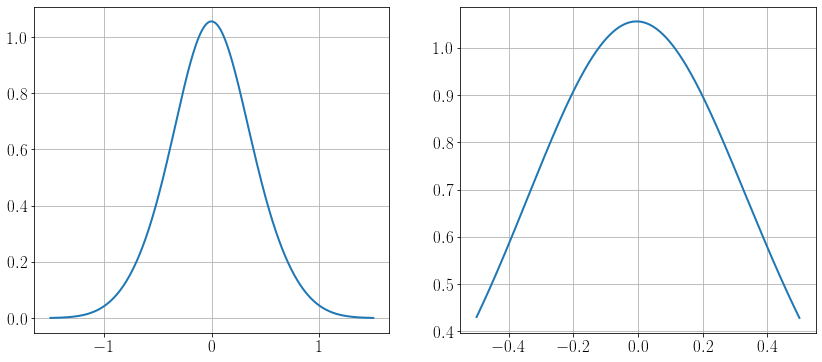

100%|██████████| 1024/1024 [00:00<00:00, 517465.94it/s]

[1.05563394]



100%|██████████| 1024/1024 [00:00<00:00, 601199.23it/s]


1.0555899141708505


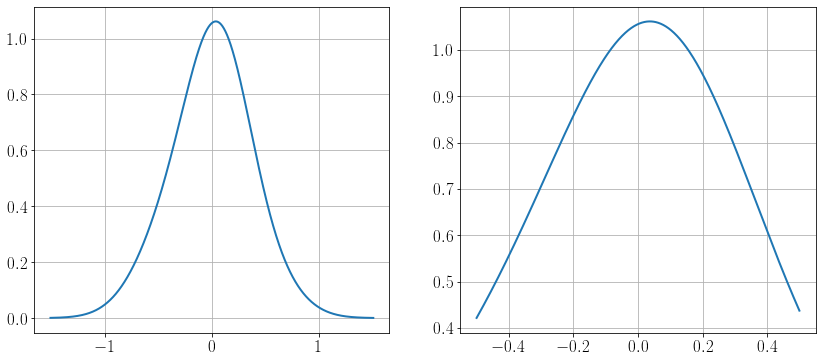

100%|██████████| 1024/1024 [00:00<00:00, 611035.32it/s]

[1.05563394]



100%|██████████| 1024/1024 [00:00<00:00, 312383.98it/s]


1.0515160844022056


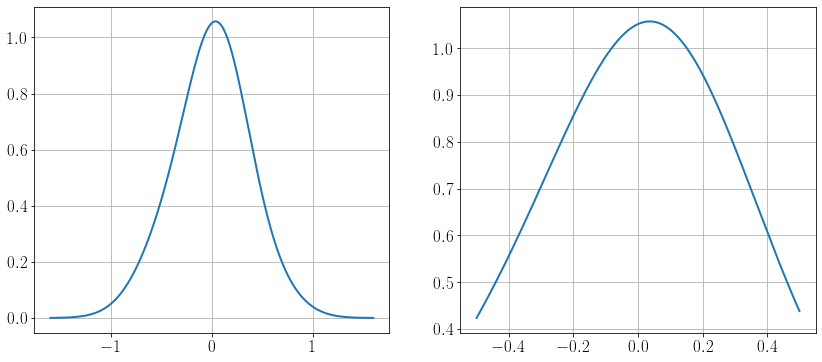

100%|██████████| 1024/1024 [00:00<00:00, 455119.98it/s]

[1.05563394]



100%|██████████| 1024/1024 [00:00<00:00, 555551.33it/s]


0.7905952838041961


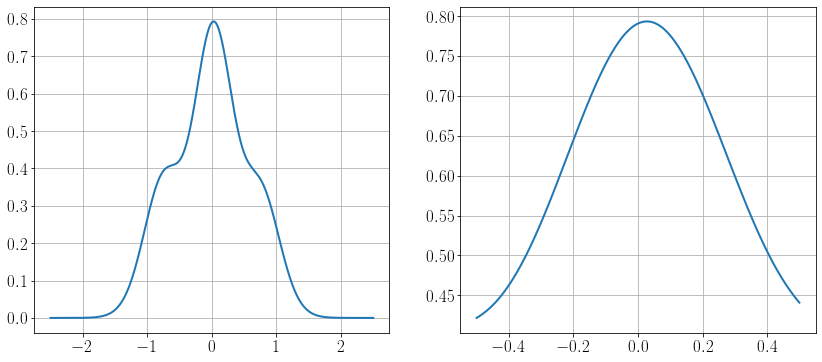

100%|██████████| 2048/2048 [00:00<00:00, 584269.80it/s]

[1.05563394]



100%|██████████| 2048/2048 [00:00<00:00, 594171.31it/s]


0.5688149086840487


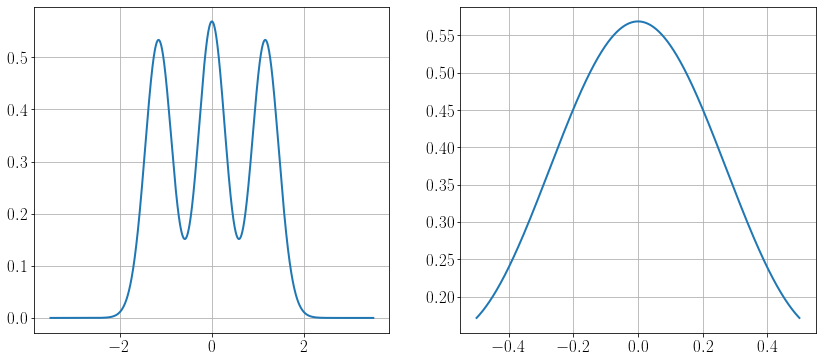

100%|██████████| 1024/1024 [00:00<00:00, 514798.91it/s]

[1.05563394]



100%|██████████| 1024/1024 [00:00<00:00, 528221.29it/s]


0.37413760535707774


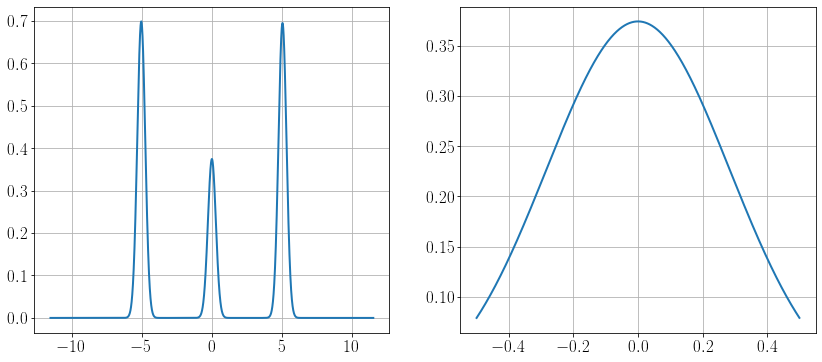

100%|██████████| 1024/1024 [00:00<00:00, 421157.81it/s]


[1.05563394]


In [ ]:
def get_rho_X(args):
#     h = 50
    (En, Xn), Xgs, flag = args
    eta = max(Ek_0)*2
    Egs = E[0]
    c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(Xgs.dims[0])-2))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    if flag == True:
        return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
    else:
        if abs(En - Egs)<10**(-4) and h > 0:
            return (h/zero_wt)*(C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
        else:
            return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

h = -1
for U in [0, 0.01, 0.1, 1, 2, 10, 100]:
    ed = -U/2
    V = 0.1
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.arange(0, Nk)/Nk
    Ek_0 = -2*V*np.cos(k_bath*a)
        
    
    w_end = U+15*V
    len_w = int(1000*w_end)
    w_range = np.linspace(-w_end, w_end, 2*len_w)
    w_range = np.insert(w_range, int(len_w), 0) if 0 not in w_range else w_range
    
    H = get_ham(Ek_0, V, ed, U)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    
    X0 = X[np.where(E == min(E))]
    X0_single = X0   
    Z = len(X0_single)
    
    A = 0
    for Ai in list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0_single, [True])), total=Z*len(E))):
        A += Ai
    zero_wt = A[np.where(w_range == 0)][0]
    print (h*A[np.where(w_range == 0)][0]/zero_wt)
    A = 0
    for Ai in list(tqdm(Pool().map(get_rho_X, product(zip(E, X), X0_single, [False])), total=Z*len(E))):
        A += Ai
    print (A[np.where(w_range == 0)][0])
    if h == -1:
        h = A[np.where(w_range == 0)]    
#     print (h)
#     print (zero_wt)
    
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(w_range, A)
    ax[1].plot(w_range[np.where(np.abs(w_range)<0.5)], A[np.where(np.abs(w_range)<0.5)])
    plt.show()